In [1]:
!nvidia-smi

Thu May 11 01:52:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.29                 Driver Version: 531.29       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti    WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8                3W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf
#Check if Tensorflow is using a GPU 
if tf.config.list_physical_devices('GPU'):    
    print("Tensorflow is using a GPU")
else: 
     print("Tensorflow is not using a GPU")

Tensorflow is using a GPU


# pix2pix model

## Generator:    
The encoder-decoder architecture consists of:
### encoder:
C64-C128-C256-C512-C512-C512-C512-C512

### decoder:
CD512-CD512-CD512-C512-C256-C128-C64


## Discriminator
C64-C128-C256-C512

- After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.    

In [4]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

Defining the generator, discriminator, gan and other helper functions
Using a functional approach

pix2pix is a conditional approach, so it takes two inputs, one image and the other label, but in this case the label is also an image (the ground truth).

The discriminator gives the likelihood of the image being real of fake (sigmoid activation function). So it gives Binary Classification (real/fake, 0/1).

The architecture for the patchGan for discriminator is: C64-C128-C256-C512
after the last layer, conv to 1-dimensional output, followed by sigmoid functions.

In [5]:
def define_discriminator(img_shape):
#     Initializing weights
    init = RandomNormal(stddev=0.02)
    
#     Source image input
    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)
    
    # Concatenate the images, channel wise
    merged = Concatenate()([in_src_img, in_target_img])
    
    #C64: 4X4 kernel, stride 2X2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.02)(d)
    
    #C128: 4x4 kernel stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.02)(d)
    
    #C256: 4x4 kernel stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.02)(d)
    
    #C512: 4x4 kernel stride 2x2
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.02)(d)
    
#     Patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
#     Defining the model
    model = Model([in_src_img, in_target_img], patch_out)

    #     Compiling the model with batch size as 1 and optimizer Adam(small learning rate and beta = 0.5)
    opt = Adam(lr = 0.0002, beta_1=0.5, beta_2=0.999)
    model.compile(loss="binary_crossentropy", optimizer=opt, loss_weights=[0.5])
    
    return model

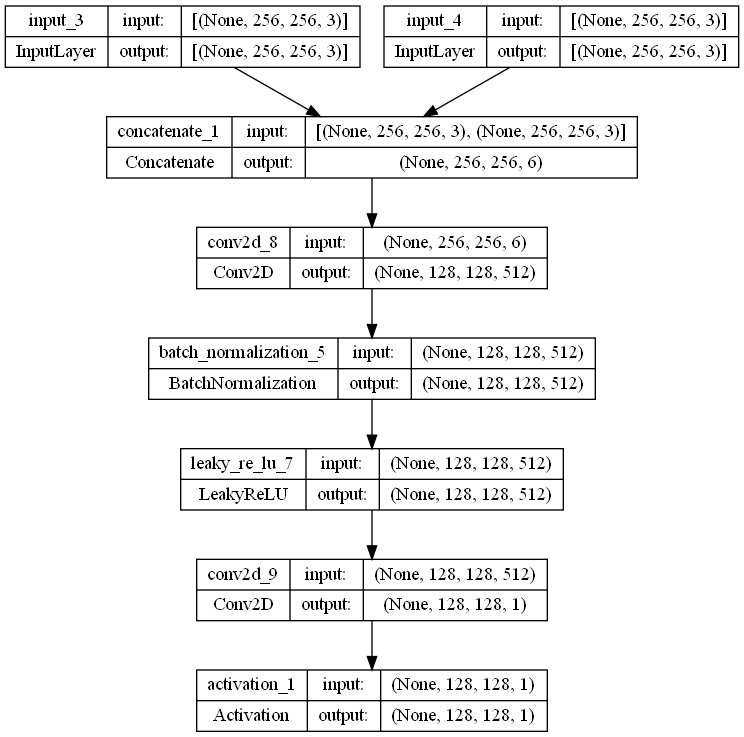

In [7]:
disc_model = define_discriminator((256,256,3))
plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

In [9]:
# Defining the U-Net Generator
def encoder_block(layer_in, n_filters, batchnorm=True):
#     Initializing the weights
    init = RandomNormal(stddev=0.02)
#     Add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    
#     add batch normalization if specifically mentioned
    if batchnorm:
        g = BatchNormalization()(g, training=True)
        
#   Leaky ReLU
    g = LeakyReLU(alpha=0.2)(g)
    
    return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
#     Initializing weights
    init = RandomNormal(stddev=0.02)
    
#     Add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    
    # relu activation
    g = Activation('relu')(g)
    
    return g

In [11]:
def define_generator(img_shape=(256,256,3)):
    init = RandomNormal(stddev=0.02)
    
    in_image = Input(shape=img_shape)
    
#     Encoder model: C64-C128-C256-C512-C512-C512-C512
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    
#     Bottleneck, no batchnorm or relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    
#     Decoder model: CD512-CD512-CD512-C512-C256-C128-C64

    d1 = decoder_block(b , e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    #     Output
    g = Conv2DTranspose(img_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    
#     Defining the model
    model = Model(in_image, out_image)
    return model

C:\Users\dhruv\miniconda3\envs\YOLO\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


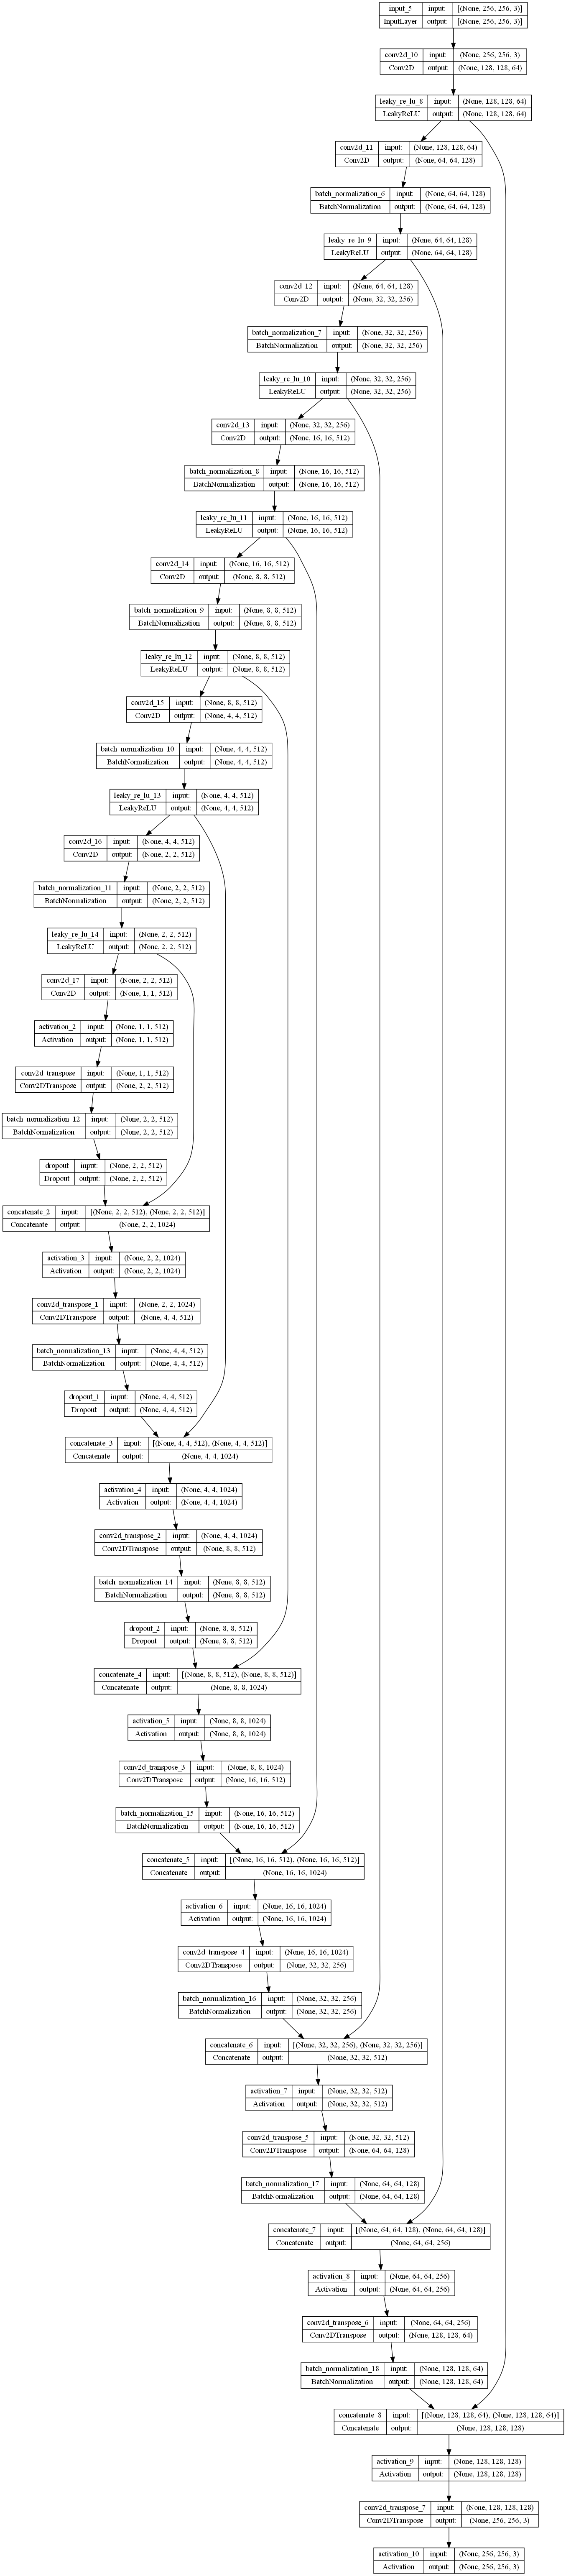

In [12]:
gen_model = define_generator((256,256,3))
plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

In [57]:
# Defining the actual GAN model using the discriminator and generator
def define_gan(g_model, d_model, image_shape):
#     make weights in discriminator non trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization): 
            # in the combined gan the discriminator layers are untrainable, but in standalone
            # discriminators, the layers are trainable             
            layer.trainable=False
    
#     Define the source image
    in_src = Input(shape=image_shape)
#     supply the input image to the generator to get a generated image
    gen_out = g_model(in_src)
#     Supply the input and generated image to the discriminator as a list
    dis_out = d_model([in_src, gen_out])
#     Compile the code

    model = Model(in_src, [dis_out, gen_out])
    
    opt = Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
#     Total loss is the weighted sum of the adversarial loss (BCE) and the L1 loss(MAE)
#     Suggested to use them in ratio of BCE:L1 is 1:100
    
    model.compile(loss = ['binary_crossentropy','mae'],
                 optimizer=opt, loss_weights=[1,100])
    
    return model

In [34]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [50]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot 


path = "join_celba/" 

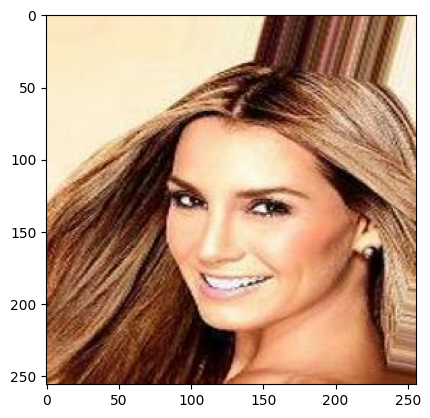

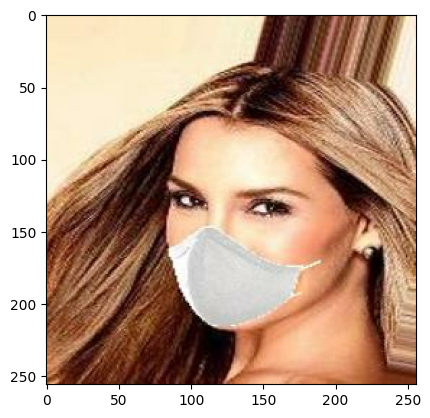

In [37]:
inp, re  = load(PATH +'000001.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [38]:
BUFFER_SIZE =1000
BATCH_SIZE = 1

IMG_WIDTH = 256
IMG_HEIGHT = 256

Loaded:  (968, 256, 256, 3) (968, 256, 256, 3)


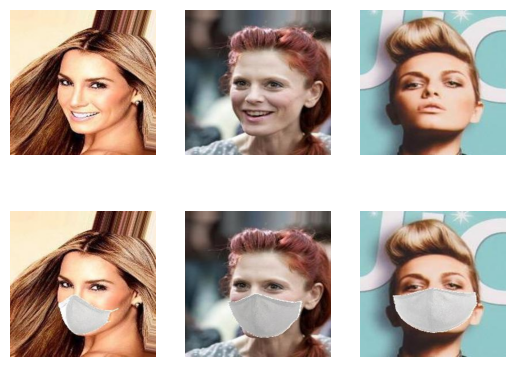

In [55]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img

from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)


n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()


In [59]:
image_shape = src_images.shape[1:]

# Define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)

# Define the data
data = [src_images, tar_images]

# Preprocess teh data to get input range between 1 and -1 coz the generator uses tanh (giving output between -1 and 1)
# So as to maintain consistency

def preprocess_data(data):
    X1,X2 = data[0],data[1]
    
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    
    return [X1, X2]

In [60]:
dataset = preprocess_data(data)

from datetime import datetime

start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1)

stop1 = datetime.now()

execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 35s 35s/step
>1, d1[1.258] d2[1.296] g[52.745]
1/1 [==============================] - 0s 360ms/step
>2, d1[0.742] d2[0.923] g[37.701]
1/1 [==============================] - 0s 83ms/step
>3, d1[0.406] d2[0.644] g[61.781]
1/1 [==============================] - 0s 159ms/step
>4, d1[0.295] d2[0.533] g[27.578]
1/1 [==============================] - 0s 80ms/step
>5, d1[0.306] d2[0.511] g[74.349]
1/1 [==============================] - 0s 165ms/step
>6, d1[0.332] d2[0.428] g[44.085]
1/1 [==============================] - 0s 322ms/step
>7, d1[0.356] d2[0.385] g[45.077]
1/1 [==============================] - 0s 51ms/step
>8, d1[0.296] d2[0.346] g[35.618]
1/1 [==============================] - 0s 42ms/step
>9, d1[0.249] d2[0.306] g[32.273]
1/1 [==============================] - 0s 55ms/step
>10, d1[0.330] d2[0.373] g[23.238]
1/1 [==============================] - 0s 67ms/step
>11, d1[0.358] d2[0.382] g[21.158]
1/1 [==============================] - 0s 416ms/

1/1 [==============================] - 0s 48ms/step
>95, d1[0.391] d2[0.334] g[18.114]
1/1 [==============================] - 0s 48ms/step
>96, d1[0.414] d2[0.431] g[21.200]
1/1 [==============================] - 0s 52ms/step
>97, d1[0.355] d2[0.373] g[13.753]
1/1 [==============================] - 0s 48ms/step
>98, d1[0.377] d2[0.358] g[11.806]
1/1 [==============================] - 0s 48ms/step
>99, d1[0.360] d2[0.400] g[11.079]
1/1 [==============================] - 0s 48ms/step
>100, d1[0.318] d2[0.375] g[16.376]
1/1 [==============================] - 0s 28ms/step
>101, d1[0.404] d2[0.458] g[11.078]
1/1 [==============================] - 0s 48ms/step
>102, d1[0.365] d2[0.378] g[14.215]
1/1 [==============================] - 0s 71ms/step
>103, d1[0.365] d2[0.372] g[17.275]
1/1 [==============================] - 0s 25ms/step
>104, d1[0.367] d2[0.424] g[9.857]
1/1 [==============================] - 0s 28ms/step
>105, d1[0.370] d2[0.401] g[20.414]
1/1 [==============================] -

1/1 [==============================] - 0s 31ms/step
>188, d1[0.358] d2[0.382] g[10.236]
1/1 [==============================] - 0s 31ms/step
>189, d1[0.348] d2[0.355] g[17.054]
1/1 [==============================] - 0s 54ms/step
>190, d1[0.375] d2[0.374] g[9.937]
1/1 [==============================] - 0s 31ms/step
>191, d1[0.344] d2[0.337] g[25.291]
1/1 [==============================] - 0s 31ms/step
>192, d1[0.399] d2[0.395] g[10.235]
1/1 [==============================] - 0s 32ms/step
>193, d1[0.344] d2[0.391] g[10.275]
1/1 [==============================] - 0s 47ms/step
>194, d1[0.350] d2[0.380] g[23.408]
1/1 [==============================] - 0s 16ms/step
>195, d1[0.383] d2[0.387] g[10.857]
1/1 [==============================] - 0s 31ms/step
>196, d1[0.387] d2[0.408] g[7.992]
1/1 [==============================] - 0s 16ms/step
>197, d1[0.356] d2[0.397] g[12.045]
1/1 [==============================] - 0s 47ms/step
>198, d1[0.373] d2[0.405] g[7.704]
1/1 [==============================

1/1 [==============================] - 0s 48ms/step
>281, d1[0.322] d2[0.426] g[9.399]
1/1 [==============================] - 0s 28ms/step
>282, d1[0.329] d2[0.416] g[10.422]
1/1 [==============================] - 0s 40ms/step
>283, d1[0.345] d2[0.414] g[15.774]
1/1 [==============================] - 0s 33ms/step
>284, d1[0.348] d2[0.377] g[11.465]
1/1 [==============================] - 0s 114ms/step
>285, d1[0.345] d2[0.386] g[12.100]
1/1 [==============================] - 0s 48ms/step
>286, d1[0.403] d2[0.362] g[8.378]
1/1 [==============================] - 0s 23ms/step
>287, d1[0.327] d2[0.395] g[12.628]
1/1 [==============================] - 0s 32ms/step
>288, d1[0.356] d2[0.411] g[8.468]
1/1 [==============================] - 0s 48ms/step
>289, d1[0.352] d2[0.374] g[9.425]
1/1 [==============================] - 0s 32ms/step
>290, d1[0.330] d2[0.424] g[10.447]
1/1 [==============================] - 0s 52ms/step
>291, d1[0.402] d2[0.381] g[11.719]
1/1 [==============================

1/1 [==============================] - 0s 38ms/step
>374, d1[0.369] d2[0.382] g[8.109]
1/1 [==============================] - 0s 70ms/step
>375, d1[0.330] d2[0.390] g[11.534]
1/1 [==============================] - 0s 37ms/step
>376, d1[0.333] d2[0.411] g[10.678]
1/1 [==============================] - 0s 31ms/step
>377, d1[0.384] d2[0.392] g[12.873]
1/1 [==============================] - 0s 55ms/step
>378, d1[0.353] d2[0.399] g[10.059]
1/1 [==============================] - 0s 25ms/step
>379, d1[0.361] d2[0.390] g[11.720]
1/1 [==============================] - 0s 32ms/step
>380, d1[0.352] d2[0.413] g[11.829]
1/1 [==============================] - 0s 48ms/step
>381, d1[0.367] d2[0.424] g[10.311]
1/1 [==============================] - 0s 32ms/step
>382, d1[0.368] d2[0.379] g[7.742]
1/1 [==============================] - 0s 29ms/step
>383, d1[0.373] d2[0.395] g[7.187]
1/1 [==============================] - 0s 94ms/step
>384, d1[0.356] d2[0.382] g[12.859]
1/1 [==============================

1/1 [==============================] - 0s 31ms/step
>468, d1[0.374] d2[0.399] g[8.738]
1/1 [==============================] - 0s 16ms/step
>469, d1[0.320] d2[0.418] g[13.219]
1/1 [==============================] - 0s 16ms/step
>470, d1[0.412] d2[0.359] g[7.893]
1/1 [==============================] - 0s 47ms/step
>471, d1[0.360] d2[0.405] g[6.220]
1/1 [==============================] - 0s 47ms/step
>472, d1[0.361] d2[0.379] g[9.736]
1/1 [==============================] - 0s 28ms/step
>473, d1[0.299] d2[0.414] g[10.440]
1/1 [==============================] - 0s 43ms/step
>474, d1[0.353] d2[0.446] g[8.141]
1/1 [==============================] - 0s 47ms/step
>475, d1[0.383] d2[0.378] g[8.020]
1/1 [==============================] - 0s 9ms/step
>476, d1[0.349] d2[0.400] g[11.044]
1/1 [==============================] - 0s 33ms/step
>477, d1[0.335] d2[0.405] g[10.400]
1/1 [==============================] - 0s 32ms/step
>478, d1[0.380] d2[0.385] g[7.639]
1/1 [==============================] - 0

1/1 [==============================] - 0s 34ms/step
>562, d1[0.352] d2[0.397] g[8.550]
1/1 [==============================] - 0s 24ms/step
>563, d1[0.337] d2[0.392] g[10.164]
1/1 [==============================] - 0s 32ms/step
>564, d1[0.335] d2[0.419] g[8.133]
1/1 [==============================] - 0s 44ms/step
>565, d1[0.356] d2[0.392] g[10.970]
1/1 [==============================] - 0s 47ms/step
>566, d1[0.336] d2[0.435] g[10.642]
1/1 [==============================] - 0s 32ms/step
>567, d1[0.349] d2[0.407] g[11.076]
1/1 [==============================] - 0s 47ms/step
>568, d1[0.352] d2[0.402] g[9.497]
1/1 [==============================] - 0s 32ms/step
>569, d1[0.372] d2[0.381] g[6.805]
1/1 [==============================] - 0s 94ms/step
>570, d1[0.345] d2[0.405] g[9.469]
1/1 [==============================] - 0s 32ms/step
>571, d1[0.361] d2[0.388] g[9.302]
1/1 [==============================] - 0s 31ms/step
>572, d1[0.368] d2[0.395] g[7.781]
1/1 [==============================] - 

1/1 [==============================] - 0s 36ms/step
>656, d1[0.353] d2[0.388] g[8.005]
1/1 [==============================] - 0s 48ms/step
>657, d1[0.357] d2[0.390] g[7.654]
1/1 [==============================] - 0s 36ms/step
>658, d1[0.335] d2[0.432] g[7.209]
1/1 [==============================] - 0s 24ms/step
>659, d1[0.351] d2[0.390] g[10.423]
1/1 [==============================] - 0s 46ms/step
>660, d1[0.371] d2[0.380] g[15.149]
1/1 [==============================] - 0s 24ms/step
>661, d1[0.329] d2[0.429] g[10.996]
1/1 [==============================] - 0s 32ms/step
>662, d1[0.320] d2[0.426] g[9.070]
1/1 [==============================] - 0s 40ms/step
>663, d1[0.319] d2[0.451] g[13.767]
1/1 [==============================] - 0s 40ms/step
>664, d1[0.339] d2[0.401] g[12.583]
1/1 [==============================] - 0s 24ms/step
>665, d1[0.363] d2[0.368] g[9.668]
1/1 [==============================] - 0s 32ms/step
>666, d1[0.330] d2[0.426] g[6.919]
1/1 [==============================] -

1/1 [==============================] - 0s 40ms/step
>750, d1[0.370] d2[0.386] g[7.376]
1/1 [==============================] - 0s 24ms/step
>751, d1[0.314] d2[0.422] g[10.096]
1/1 [==============================] - 0s 24ms/step
>752, d1[0.352] d2[0.410] g[6.761]
1/1 [==============================] - 0s 44ms/step
>753, d1[0.337] d2[0.412] g[8.535]
1/1 [==============================] - 0s 28ms/step
>754, d1[0.321] d2[0.411] g[10.568]
1/1 [==============================] - 0s 48ms/step
>755, d1[0.342] d2[0.412] g[7.713]
1/1 [==============================] - 0s 24ms/step
>756, d1[0.341] d2[0.430] g[7.507]
1/1 [==============================] - 0s 24ms/step
>757, d1[0.347] d2[0.405] g[7.452]
1/1 [==============================] - 0s 40ms/step
>758, d1[0.350] d2[0.402] g[10.677]
1/1 [==============================] - 0s 28ms/step
>759, d1[0.330] d2[0.419] g[6.188]
1/1 [==============================] - 0s 28ms/step
>760, d1[0.329] d2[0.417] g[6.479]
1/1 [==============================] - 0

1/1 [==============================] - 0s 43ms/step
>844, d1[0.340] d2[0.400] g[8.903]
1/1 [==============================] - 0s 16ms/step
>845, d1[0.355] d2[0.387] g[6.586]
1/1 [==============================] - 0s 16ms/step
>846, d1[0.337] d2[0.422] g[8.642]
1/1 [==============================] - 0s 16ms/step
>847, d1[0.338] d2[0.417] g[7.940]
1/1 [==============================] - 0s 16ms/step
>848, d1[0.324] d2[0.410] g[7.074]
1/1 [==============================] - 0s 16ms/step
>849, d1[0.346] d2[0.392] g[12.931]
1/1 [==============================] - 0s 47ms/step
>850, d1[0.321] d2[0.439] g[7.140]
1/1 [==============================] - 0s 31ms/step
>851, d1[0.336] d2[0.412] g[10.465]
1/1 [==============================] - 0s 31ms/step
>852, d1[0.327] d2[0.412] g[6.803]
1/1 [==============================] - 0s 31ms/step
>853, d1[0.347] d2[0.411] g[10.344]
1/1 [==============================] - 0s 47ms/step
>854, d1[0.345] d2[0.395] g[9.167]
1/1 [==============================] - 0

1/1 [==============================] - 0s 24ms/step
>938, d1[0.325] d2[0.445] g[7.402]
1/1 [==============================] - 0s 24ms/step
>939, d1[0.303] d2[0.430] g[8.004]
1/1 [==============================] - 0s 32ms/step
>940, d1[0.369] d2[0.375] g[6.658]
1/1 [==============================] - 0s 40ms/step
>941, d1[0.320] d2[0.427] g[4.603]
1/1 [==============================] - 0s 24ms/step
>942, d1[0.384] d2[0.386] g[8.489]
1/1 [==============================] - 0s 32ms/step
>943, d1[0.336] d2[0.394] g[9.851]
1/1 [==============================] - 0s 28ms/step
>944, d1[0.349] d2[0.402] g[6.589]
1/1 [==============================] - 0s 20ms/step
>945, d1[0.324] d2[0.412] g[5.159]
1/1 [==============================] - 0s 28ms/step
>946, d1[0.320] d2[0.422] g[6.854]
1/1 [==============================] - 0s 29ms/step
>947, d1[0.336] d2[0.427] g[6.801]
1/1 [==============================] - 0s 33ms/step
>948, d1[0.346] d2[0.408] g[6.225]
1/1 [==============================] - 0s 4

In [61]:
g_model.save('unmask.h5')

## Loading the model now

Model loaded
1/1 [==============================] - 13s 13s/step


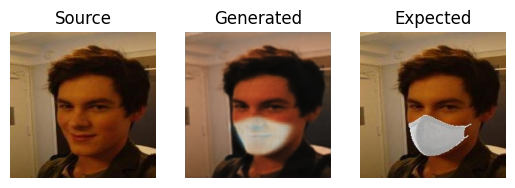

In [66]:
from keras.models import load_model
from numpy.random import randint
from numpy import vstack

model = load_model('unmask.h5')

print("Model loaded")

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.show()

def preprocess_data(data):
    X1,X2 = data[0],data[1]
    
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    
    return [X1, X2]

dataset = preprocess_data(data)

[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)
